### Hierarchical Models or Multilevel Models

Perform an analysis of water quality in a state and information is available from each district in the state. There are two ways to model this now:

* Study each district separately, however we lose information especially if there is insufficient data for some districts. But we get a more detailed model per district.

* The second option is to combine all the data and estimate the water quality of the state as a whole, i.e. a pooled model. We have more data but we lose granular information about each district.

The hierarchical model combines both of these options, by sharing information between the districts using hyperpriors that are priors over the parameter priors. In other words, instead of setting the prior parameters (or hyperparameters) to a constant value, we draw it from another prior distribution called the hyperprior. This hyperprior is shared among all the districts, and as a result information is shared between all the groups in the data.

#### Problem Statement

We measure the water samples for three districts, and we collect 30 samples for each district. The data is simply a binary value that indicates whether the water is contaminated or not. We count the number of samples that have contamination below the acceptable levels. We generate three arrays:

* N_samples - The total number of samples collected for each district or group
* G_samples - The number of good samples or samples with contamination levels below a certain threshold
* group_idx - The id for each district or group

#### Artifically generate the data

In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import os
import pymc as pm

In [2]:
N_samples = [30, 30, 30] # Total number of samples collected
G_samples = [18, 18, 18] # Number of samples with water contamination
                         # below accepted levels
# Create an ID for each of the 30 + 30 + 30 samples - 0,1,2 to indicate that they
# belong to different groups
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))


In [3]:
# ID per sample
group_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

#### The Sampling Model

The scenario presented here is essentially a binary classification problem that can be modeled using a Bernoulli distribution. The parameter of the Bernoulli distribution is a vector corresponding to each group (\\(\theta_1, \theta_2, \theta_3\\)) and indicates the probability of getting a good sample (in each group). Since this is a hierarchical model, each group shares information and as a result the parameter of Group 1 can be influenced by the samples in Group 2 and 3. This is what makes hierarchical modeling so powerful.

The process of generating our samples looks like the following. If we start from the last equation and work our way up, we can see that $\theta_i$ and $y_i$ are similar to a pooled model except that the beta prior takes parameters $\alpha$ and $\beta$ instead of constant values. These parameters now have hyperpriors applied to them using the parameters $\mu$ and *k* which are assumed to be distributed using a beta distribution and a half-Normal distribution respectively. Note that $\alpha$ and $\beta$ are indirectly computed from the terms \\(\mu\\) and *k* here. \\(\mu\\) affects the mean of the beta distribution and increasing *k* makes the beta distribution more concentrated. This parameterization is more efficient than the direct parameterization in terms of $\alpha_i$ and $\beta_i$.


$$ \mu \sim Beta(\alpha_p, \beta_p)  $$
$$ k \sim | Normal(0,\sigma_k) | $$
$$  \alpha =  \mu * k $$
$$  \beta = (1 - \mu) * k $$
$$  \theta_i \sim Beta(\alpha, \beta) $$
$$  y_i \sim Bern(\theta_i) $$




Output()

Output()

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   7.211  3.810   1.078   14.599      0.073    0.052    2470.0    2262.0   
beta    5.068  2.732   0.684   10.102      0.052    0.038    2603.0    2080.0   
θ[0]    0.596  0.079   0.449    0.741      0.001    0.001    3834.0    2891.0   
θ[1]    0.596  0.080   0.447    0.741      0.001    0.001    3002.0    2552.0   
θ[2]    0.595  0.080   0.454    0.749      0.001    0.001    3540.0    2985.0   
κ      12.279  6.120   2.522   24.109      0.119    0.084    2469.0    2285.0   
μ       0.585  0.097   0.413    0.777      0.002    0.001    3161.0    2843.0   

       r_hat  
alpha    1.0  
beta     1.0  
θ[0]     1.0  
θ[1]     1.0  
θ[2]     1.0  
κ        1.0  
μ        1.0  


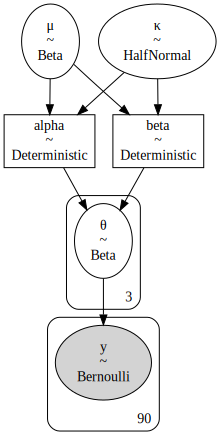

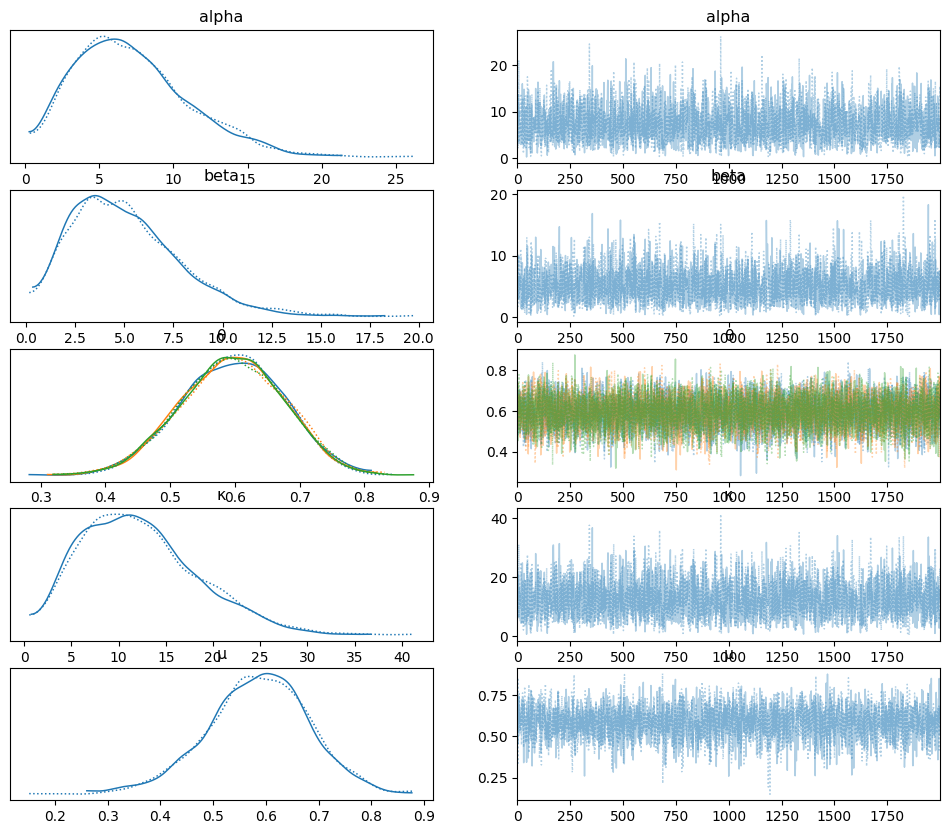

In [4]:
def get_hyperprior_model(data, N_samples, group_idx):
    with pm.Model() as model_h:
        μ = pm.Beta('μ', 1., 1.) # hyperprior
        κ = pm.HalfNormal('κ', 10) # hyperprior
        alpha = pm.Deterministic('alpha', μ*κ)
        beta = pm.Deterministic('beta', (1.0-μ)*κ)
        θ = pm.Beta('θ', alpha=alpha, beta=beta, shape=len(N_samples)) # prior, len(N_samples) = 3
        y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
        trace_h = pm.sample(2000)
    az.plot_trace(trace_h)
    print(az.summary(trace_h))
    return(model_h)

model = get_hyperprior_model(data, N_samples, group_idx)
pm.model_to_graphviz(model)